# H2 — Comparison of 4 datasets: av-1, av-2, rw-1, rw-2

## Contents

1. **Across 4 datasets — Stage I**: violin plots of correlations (NREM I + REM I pooled) for each dataset side by side
2. **Across 4 datasets — Stage II**: same for NREM II + REM II
3. **Shift Δ = Stage II − Stage I**: for each dataset, **bootstrap distribution of Δ** (violin), in the `av-1 | av-2 ┆ rw-1 | rw-2` layout
4. **KDE per dataset**: full distribution of correlations per dataset and per stage
5. **Statistical tests**: global Kruskal-Wallis + pairwise Mann-Whitney U across 4 datasets
6. **Rewarded vs Aversive**: Stage II − Stage I shift, interaction test and KDE density difference

## Color codes
- `av-1`: dark red
- `av-2`: light red
- `rw-1`: dark blue
- `rw-2`: light blue

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

In [2]:
# --- Load the 4 datasets ---
DATASETS_RAW = {
    'av-1': pd.read_pickle('data/lfp_epochs_with_spikes_by_region-av-1.pkl'),
    'av-2': pd.read_pickle('data/lfp_epochs_with_spikes_by_region-av-2.pkl'),
    'rw-1': pd.read_pickle('data/lfp_epochs_with_spikes_by_region-rw-1.pkl'),
    'rw-2': pd.read_pickle('data/lfp_epochs_with_spikes_by_region-rw-2.pkl'),
}

STAGE_I_LABELS  = {'NREM I',  'REM I'}
STAGE_II_LABELS = {'NREM II', 'REM II'}

# DATASETS[(name, 'Stage I')] and DATASETS[(name, 'Stage II')]
DATASETS = {}
for name, df in DATASETS_RAW.items():
    DATASETS[(name, 'Stage I')]  = df[df['epoch_label'].isin(STAGE_I_LABELS)].reset_index(drop=True)
    DATASETS[(name, 'Stage II')] = df[df['epoch_label'].isin(STAGE_II_LABELS)].reset_index(drop=True)

# Colors and styles
COLORS = {
    'av-1': '#922b21',  # dark red
    'av-2': '#e74c3c',  # light red
    'rw-1': '#1a5276',  # dark blue
    'rw-2': '#3498db',  # light blue
}
FACE_COLORS = {
    'av-1': '#f1948a',
    'av-2': '#fadbd8',
    'rw-1': '#7fb3d3',
    'rw-2': '#d6eaf8',
}
DATASET_NAMES = list(DATASETS_RAW.keys())
STAGES = ['Stage I', 'Stage II']

# Summary
print(f"{'Dataset':<8} {'Stage':<10} {'n epochs':>9}  {'Total time (s)':>15}  Labels")
print('-' * 75)

for name in DATASET_NAMES:
    for stage in STAGES:
        df = DATASETS[(name, stage)]
        counts = df['epoch_label'].value_counts().to_dict()
        d = df['t_end'] - df['t_start']
        total_time = d.sum()

        print(f"{name:<8} {stage:<10} {len(df):>9}  "
              f"{total_time:>15.1f}  "
              f"{counts}  "
              f"(mean={d.mean():.1f}s)")

Dataset  Stage       n epochs   Total time (s)  Labels
---------------------------------------------------------------------------
av-1     Stage I          525           8171.0  {'NREM I': 268, 'REM I': 257}  (mean=15.6s)
av-1     Stage II         490           6602.0  {'NREM II': 248, 'REM II': 242}  (mean=13.5s)
av-2     Stage I           52           4005.0  {'NREM I': 32, 'REM I': 20}  (mean=77.0s)
av-2     Stage II          43           4513.0  {'NREM II': 26, 'REM II': 17}  (mean=105.0s)
rw-1     Stage I           16           3536.0  {'REM I': 8, 'NREM I': 8}  (mean=221.0s)
rw-1     Stage II          10           2278.0  {'REM II': 5, 'NREM II': 5}  (mean=227.8s)
rw-2     Stage I          362           8206.0  {'NREM I': 184, 'REM I': 178}  (mean=22.7s)
rw-2     Stage II         396           7292.0  {'NREM II': 203, 'REM II': 193}  (mean=18.4s)


In [3]:
PAIRS = [
    ('vHPC_lfp', 'dHPC_lfp', 'vHPC ↔ dHPC', '#1f77b4'),
    ('bla_lfp',  'dHPC_lfp', 'BLA ↔ dHPC',  '#ff7f0e'),
    ('bla_lfp',  'vHPC_lfp', 'BLA ↔ vHPC',  '#2ca02c'),
]


def compute_weighted_correlations(df, name1, name2, min_samples=1000, min_std=0.01):
    corrs   = np.full(len(df), np.nan)
    weights = np.zeros(len(df))
    for i, (_, row) in enumerate(df.iterrows()):
        sig1 = np.asarray(row[name1])
        sig2 = np.asarray(row[name2])
        if (len(sig1) < min_samples or
            np.std(sig1) < min_std or
            np.std(sig2) < min_std):
            continue
        corrs[i]   = np.corrcoef(sig1, sig2)[0, 1]
        weights[i] = row['t_end'] - row['t_start']
    return corrs, weights


def get_valid(corrs, weights):
    mask = ~np.isnan(corrs) & (weights > 0)
    return corrs[mask], weights[mask]


def weighted_mean_std(values, weights):
    wn   = weights / weights.sum()
    mean = np.dot(wn, values)
    std  = np.sqrt(np.dot(wn, (values - mean) ** 2))
    return mean, std


def sig_label(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'


def mwu(a, b):
    if len(a) < 3 or len(b) < 3:
        return np.nan, np.nan
    stat, p = stats.mannwhitneyu(a, b, alternative='two-sided')
    return stat, p


# --- Pre-compute all correlations ---
# corr_cache[(dataset_name, stage, pair_label)] = (corrs_valid, weights_valid)
corr_cache = {}
for name in DATASET_NAMES:
    for stage in STAGES:
        df = DATASETS[(name, stage)]
        for n1, n2, pair_label, _ in PAIRS:
            c, w = compute_weighted_correlations(df, n1, n2)
            corr_cache[(name, stage, pair_label)] = get_valid(c, w)

print("Correlations computed for all combinations.")
print(f"{'Dataset':<8} {'Stage':<10} {'Pair':<18} {'n valid':>8}")
print('-' * 50)
for name in DATASET_NAMES:
    for stage in STAGES:
        for _, _, pair_label, _ in PAIRS:
            n = len(corr_cache[(name, stage, pair_label)][0])
            print(f"{name:<8} {stage:<10} {pair_label:<18} {n:>8}")

Correlations computed for all combinations.
Dataset  Stage      Pair                n valid
--------------------------------------------------
av-1     Stage I    vHPC ↔ dHPC             520
av-1     Stage I    BLA ↔ dHPC              520
av-1     Stage I    BLA ↔ vHPC              520
av-1     Stage II   vHPC ↔ dHPC             488
av-1     Stage II   BLA ↔ dHPC              488
av-1     Stage II   BLA ↔ vHPC              488
av-2     Stage I    vHPC ↔ dHPC              52
av-2     Stage I    BLA ↔ dHPC               52
av-2     Stage I    BLA ↔ vHPC               52
av-2     Stage II   vHPC ↔ dHPC              43
av-2     Stage II   BLA ↔ dHPC               43
av-2     Stage II   BLA ↔ vHPC               43
rw-1     Stage I    vHPC ↔ dHPC              16
rw-1     Stage I    BLA ↔ dHPC               16
rw-1     Stage I    BLA ↔ vHPC               16
rw-1     Stage II   vHPC ↔ dHPC              10
rw-1     Stage II   BLA ↔ dHPC               10
rw-1     Stage II   BLA ↔ vHPC           

## Figure 1 — Comparison of 4 datasets: Stage I

The 4 datasets side by side, for each region pair (NREM I + REM I pooled).

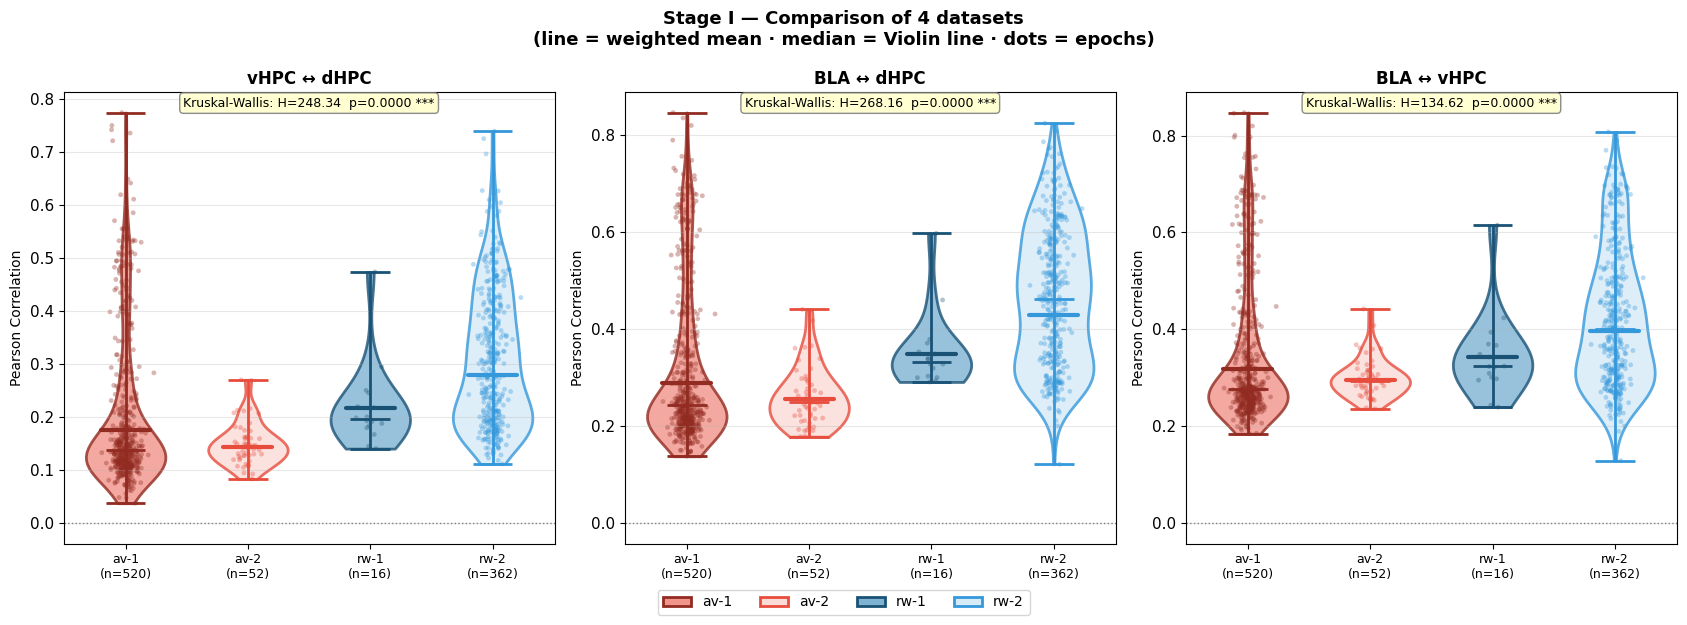

In [4]:
def violin_4datasets(stage, title_suffix=''):
    """Violin plots of 4 datasets side by side for a given stage."""
    fig, axes = plt.subplots(1, 3, figsize=(17, 6))

    for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
        ax = axes[pi]
        positions = [1, 2, 3, 4]
        all_data  = [corr_cache[(name, stage, pair_label)][0] for name in DATASET_NAMES]
        all_w     = [corr_cache[(name, stage, pair_label)][1] for name in DATASET_NAMES]

        for pos, name, d, w in zip(positions, DATASET_NAMES, all_data, all_w):
            if len(d) < 2:
                continue

            vp = ax.violinplot([d], positions=[pos], showmedians=True, widths=0.65)
            vp['bodies'][0].set_facecolor(FACE_COLORS[name])
            vp['bodies'][0].set_edgecolor(COLORS[name])
            vp['bodies'][0].set_linewidth(2)
            vp['bodies'][0].set_alpha(0.8)
            for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
                vp[part].set_color(COLORS[name])
                vp[part].set_linewidth(2)

            # Scatter jitter
            np.random.seed(42)
            ax.scatter(np.random.normal(pos, 0.06, len(d)), d,
                       alpha=0.35, s=12, color=COLORS[name], edgecolors='none')

            # Weighted mean
            if len(w) > 0:
                wm, _ = weighted_mean_std(d, w)
                ax.plot([pos - 0.2, pos + 0.2], [wm, wm],
                        color=COLORS[name], lw=3, solid_capstyle='round')

        # Global Kruskal-Wallis test
        valid_groups = [d for d in all_data if len(d) >= 3]
        if len(valid_groups) >= 2:
            kw_stat, kw_p = stats.kruskal(*valid_groups)
            ax.text(0.5, 0.99,
                    f'Kruskal-Wallis: H={kw_stat:.2f}  p={kw_p:.4f} {sig_label(kw_p)}',
                    transform=ax.transAxes, ha='center', va='top', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='#FFFFCC' if kw_p < 0.05 else '#F0F0F0',
                              alpha=0.9, edgecolor='gray'))

        ax.set_xticks(positions)
        ax.set_xticklabels(
            [f"{name}\n(n={len(corr_cache[(name, stage, pair_label)][0])})"
             for name in DATASET_NAMES],
            fontsize=9
        )
        ax.set_ylabel('Pearson Correlation', fontsize=10)
        ax.set_title(pair_label, fontsize=12, fontweight='bold')
        ax.axhline(0, color='gray', linestyle=':', lw=1)
        ax.grid(True, alpha=0.3, axis='y')

    # Legend
    legend_patches = [
        mpatches.Patch(facecolor=FACE_COLORS[name], edgecolor=COLORS[name],
                       linewidth=2, label=name)
        for name in DATASET_NAMES
    ]
    fig.legend(handles=legend_patches, loc='lower center', ncol=4,
               fontsize=10, frameon=True,
               bbox_to_anchor=(0.5, -0.04))

    plt.suptitle(f'{stage} — Comparison of 4 datasets{title_suffix}\n'
                 '(line = weighted mean · median = Violin line · dots = epochs)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


violin_4datasets('Stage I')

## Figure 2 — Comparison of 4 datasets: Stage II

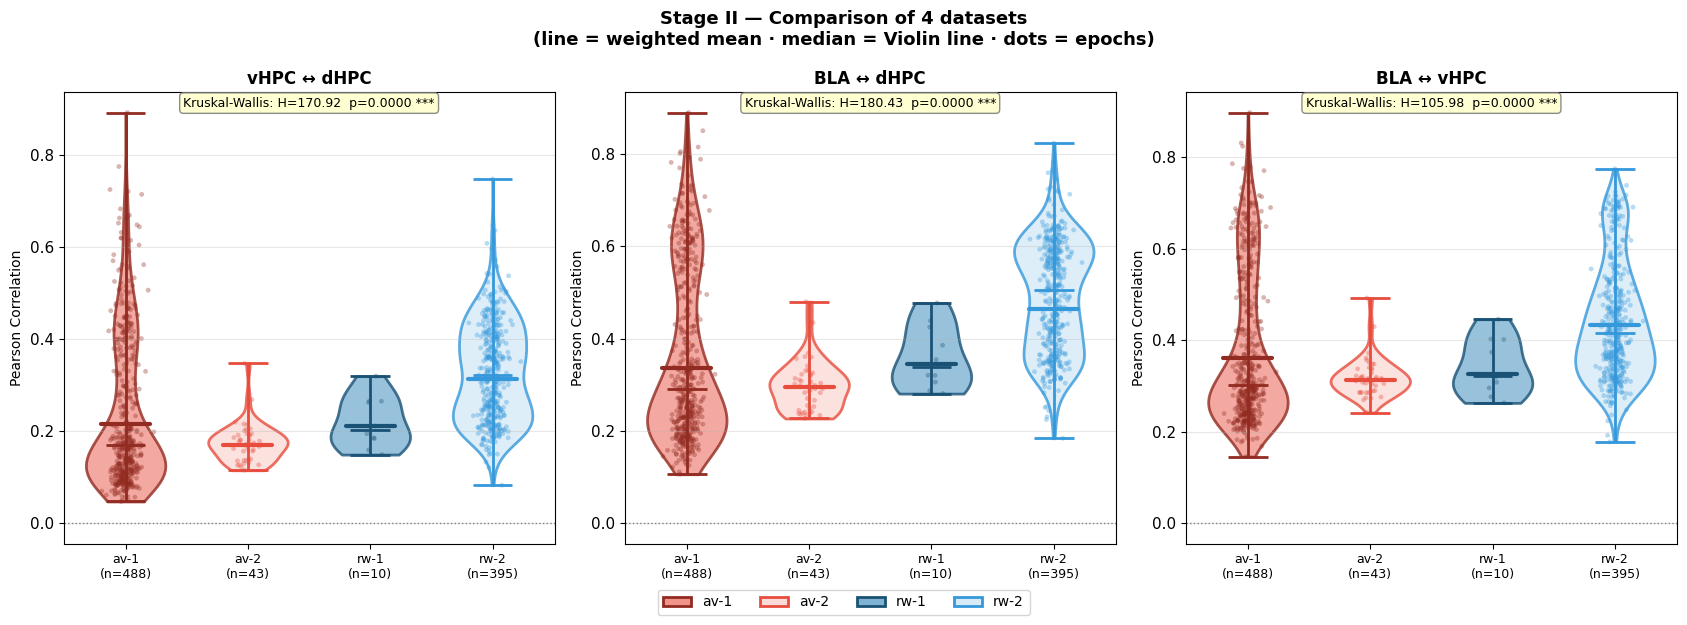

In [5]:
violin_4datasets('Stage II')

## Figure 3 — Shift Δ = wmean(Stage II) − wmean(Stage I) per dataset

For each region pair: **bootstrap distribution of Δ** for the 4 datasets, displayed in the same layout as H1 (`av-1 | av-2 ┆ rw-1 | rw-2`).

- **Violin** = bootstrap distribution of Δ (5,000 weighted resamples, with replacement)
- **Thick line** = observed Δ (wmean Stage II − wmean Stage I)
- **Transparent band** = 95% bootstrap CI
- **Red dashed line** = Δ = 0
- **Annotation** = p-value of weighted permutation test (H₀: Δ = 0, two-sided, 5,000 iterations)

Shifts Δ computed.
  av-1   | vHPC ↔ dHPC        n₁= 520 n₂= 488 | Δ=+0.0402  p=0.0020 **  CI=[0.0237,0.0573]
  av-1   | BLA ↔ dHPC         n₁= 520 n₂= 488 | Δ=+0.0482  p=0.0016 **  CI=[0.0289,0.0679]
  av-1   | BLA ↔ vHPC         n₁= 520 n₂= 488 | Δ=+0.0437  p=0.0012 **  CI=[0.0264,0.0613]
  av-2   | vHPC ↔ dHPC        n₁=  52 n₂=  43 | Δ=+0.0263  p=0.0004 ***  CI=[0.0123,0.0411]
  av-2   | BLA ↔ dHPC         n₁=  52 n₂=  43 | Δ=+0.0397  p=0.0010 **  CI=[0.0199,0.0602]
  av-2   | BLA ↔ vHPC         n₁=  52 n₂=  43 | Δ=+0.0188  p=0.0150 *  CI=[0.0048,0.0333]
  rw-1   | vHPC ↔ dHPC        n₁=  16 n₂=  10 | Δ=-0.0079  p=0.7222 ns  CI=[-0.0481,0.0302]
  rw-1   | BLA ↔ dHPC         n₁=  16 n₂=  10 | Δ=-0.0031  p=0.8948 ns  CI=[-0.0478,0.0410]
  rw-1   | BLA ↔ vHPC         n₁=  16 n₂=  10 | Δ=-0.0164  p=0.4992 ns  CI=[-0.0608,0.0271]
  rw-2   | vHPC ↔ dHPC        n₁= 362 n₂= 395 | Δ=+0.0325  p=0.0404 *  CI=[0.0156,0.0489]
  rw-2   | BLA ↔ dHPC         n₁= 362 n₂= 395 | Δ=+0.0354  p=0.0524 n

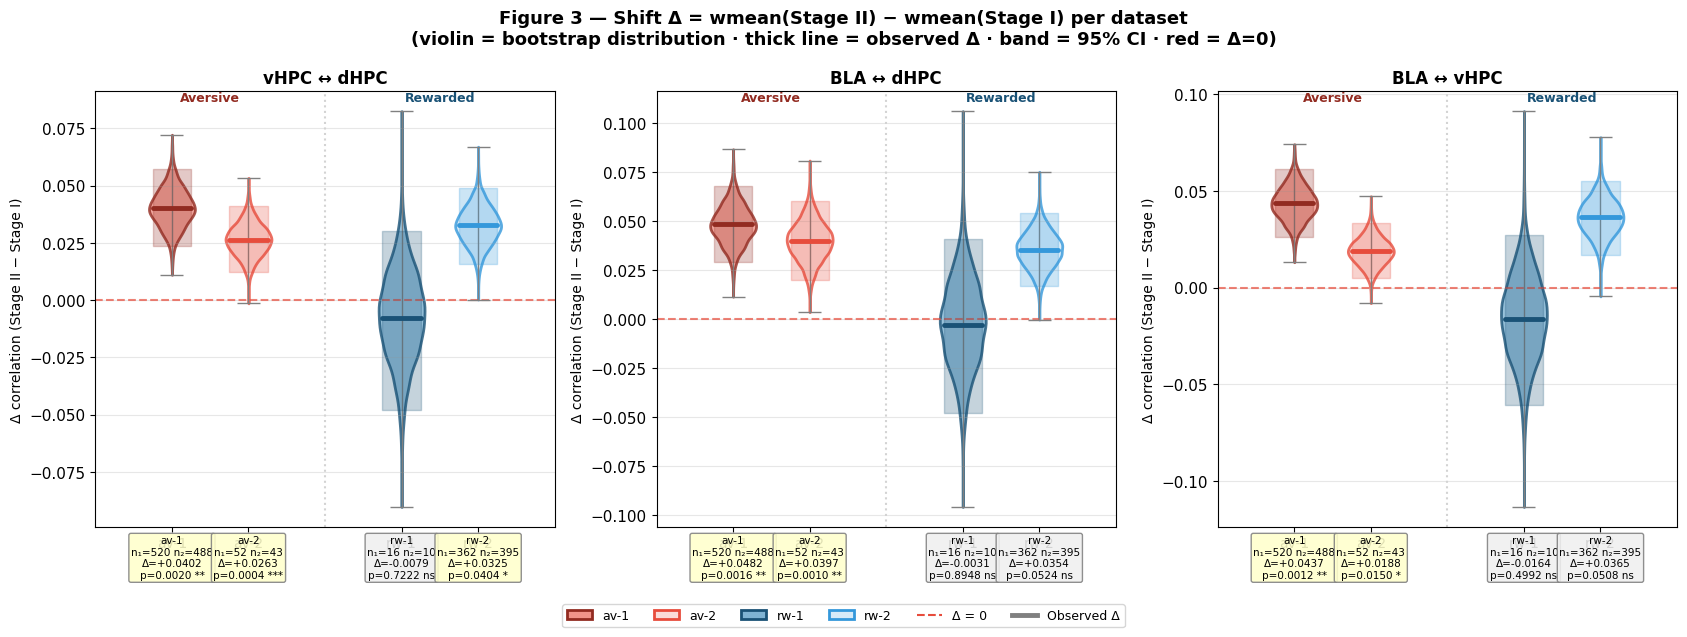

In [6]:

# ── Bootstrap and permutation functions ───────────────────────────────────

N_BOOT = 5_000

def _perm_test_delta(d_s1, w_s1, d_s2, w_s2, n_perm=5000):
    """Weighted permutation test — H0: Δ = 0 (two-sided)."""
    obs = np.dot(w_s2/w_s2.sum(), d_s2) - np.dot(w_s1/w_s1.sum(), d_s1)
    pool   = np.concatenate([d_s1, d_s2])
    w_pool = np.concatenate([w_s1, w_s2])
    n1 = len(d_s1)
    rng = np.random.default_rng(42)
    perm = np.empty(n_perm)
    for i in range(n_perm):
        idx = rng.permutation(len(pool))
        a, wa = pool[idx[:n1]], w_pool[idx[:n1]]
        b, wb = pool[idx[n1:]], w_pool[idx[n1:]]
        perm[i] = np.dot(wb/wb.sum(), b) - np.dot(wa/wa.sum(), a)
    return obs, float(np.mean(np.abs(perm) >= np.abs(obs)))


def _bootstrap_delta(d_s1, w_s1, d_s2, w_s2, n_boot=N_BOOT):
    """Bootstrap distribution of Δ = wmean(S2) − wmean(S1)."""
    rng = np.random.default_rng(42)
    p1, p2 = w_s1 / w_s1.sum(), w_s2 / w_s2.sum()
    deltas = np.empty(n_boot)
    for i in range(n_boot):
        idx1 = rng.choice(len(d_s1), size=len(d_s1), replace=True, p=p1)
        idx2 = rng.choice(len(d_s2), size=len(d_s2), replace=True, p=p2)
        deltas[i] = d_s2[idx2].mean() - d_s1[idx1].mean()
    return deltas


# ── Pre-compute: Δ_obs + bootstrap + permutation for all 4 datasets ─────
# delta_cache_fig3[(name, pair_label)] = (delta_obs, boot, p_perm, ci_l, ci_h, n1, n2)

delta_cache_fig3 = {}
for name in DATASET_NAMES:
    for _, _, pair_label, _ in PAIRS:
        d_s1, w_s1 = corr_cache[(name, 'Stage I',  pair_label)]
        d_s2, w_s2 = corr_cache[(name, 'Stage II', pair_label)]
        n1, n2 = len(d_s1), len(d_s2)
        if n1 < 3 or n2 < 3:
            delta_cache_fig3[(name, pair_label)] = (np.nan, None, np.nan, np.nan, np.nan, n1, n2)
            continue
        delta_obs, p_perm = _perm_test_delta(d_s1, w_s1, d_s2, w_s2)
        boot = _bootstrap_delta(d_s1, w_s1, d_s2, w_s2)
        ci_l, ci_h = np.percentile(boot, [2.5, 97.5])
        delta_cache_fig3[(name, pair_label)] = (delta_obs, boot, p_perm, ci_l, ci_h, n1, n2)

print("Shifts Δ computed.")
for name in DATASET_NAMES:
    for _, _, pair_label, _ in PAIRS:
        d_obs, _, p, ci_l, ci_h, n1, n2 = delta_cache_fig3[(name, pair_label)]
        s = sig_label(p) if not np.isnan(p) else 'n.a.'
        print(f"  {name:<6} | {pair_label:<18} n₁={n1:>4} n₂={n2:>4} "
              f"| Δ={d_obs:+.4f}  p={p:.4f} {s}  CI=[{ci_l:.4f},{ci_h:.4f}]")


# ── Figure 3 ──────────────────────────────────────────────────────────────
POSITIONS_F3 = {'av-1': 1, 'av-2': 2, 'rw-1': 4, 'rw-2': 5}

fig, axes = plt.subplots(1, 3, figsize=(17, 6))
fig.suptitle(
    'Figure 3 — Shift Δ = wmean(Stage II) − wmean(Stage I) per dataset\n'
    '(violin = bootstrap distribution · thick line = observed Δ · band = 95% CI · red = Δ=0)',
    fontsize=13, fontweight='bold'
)

for pi, (_, _, pair_label, _) in enumerate(PAIRS):
    ax = axes[pi]

    ax.axhline(0, color='#e74c3c', linestyle='--', lw=1.5, alpha=0.7)
    ax.axvline(3, color='lightgray', linestyle=':', lw=1.5)

    # 1. Lists for violinplot
    data_list  = []
    pos_list   = []
    for name in DATASET_NAMES:
        boot = delta_cache_fig3[(name, pair_label)][1]
        data_list.append(boot if boot is not None and len(boot) > 1 else np.array([0.0]))
        pos_list.append(POSITIONS_F3[name])

    # 2. Violins
    vp = ax.violinplot(data_list, positions=pos_list, showmedians=False, widths=0.6)
    for body, name in zip(vp['bodies'], DATASET_NAMES):
        body.set_facecolor(FACE_COLORS[name])
        body.set_edgecolor(COLORS[name])
        body.set_linewidth(2)
        body.set_alpha(0.8)
    for part in ['cbars', 'cmins', 'cmaxes']:
        vp[part].set_color('gray')
        vp[part].set_linewidth(1)

    # 3. Observed Δ + 95% CI
    for name, pos in POSITIONS_F3.items():
        d_obs, _, p, ci_l, ci_h, n1, n2 = delta_cache_fig3[(name, pair_label)]
        if not np.isnan(d_obs):
            ax.plot([pos - 0.25, pos + 0.25], [d_obs, d_obs],
                    color=COLORS[name], lw=3.5, solid_capstyle='round', zorder=5)
            ax.fill_between([pos - 0.25, pos + 0.25], ci_l, ci_h,
                            color=COLORS[name], alpha=0.25, zorder=3)

    # 4. Annotations (after y-limits are set by the violins)
    y_lo, y_hi = ax.get_ylim()
    margin = (y_hi - y_lo) * 0.02
    for name, pos in POSITIONS_F3.items():
        d_obs, _, p, ci_l, ci_h, n1, n2 = delta_cache_fig3[(name, pair_label)]
        sig = sig_label(p) if not np.isnan(p) else 'n.a.'
        bg  = '#FFFFCC' if (not np.isnan(p) and p < 0.05) else '#F0F0F0'
        ax.text(pos, y_lo - margin,
                f'{name}\nn₁={n1} n₂={n2}\nΔ={d_obs:+.4f}\np={p:.4f} {sig}',
                ha='center', va='top', fontsize=7.5, clip_on=False,
                bbox=dict(boxstyle='round,pad=0.2', facecolor=bg,
                          alpha=0.88, edgecolor='gray'))

    # 5. Condition labels
    ax.text(1.5, y_hi, 'Aversive', ha='center', va='top',
            fontsize=9, color='#922b21', fontweight='bold')
    ax.text(4.5, y_hi, 'Rewarded', ha='center', va='top',
            fontsize=9, color='#1a5276', fontweight='bold')

    ax.set_title(pair_label, fontsize=12, fontweight='bold')
    ax.set_ylabel('Δ correlation (Stage II − Stage I)', fontsize=10)
    ax.set_xticks([1, 2, 4, 5])
    ax.set_xticklabels(['av-1', 'av-2', 'rw-1', 'rw-2'], fontsize=10)
    ax.set_xlim(0, 6)
    ax.grid(True, axis='y', alpha=0.3)

# Legend
patches  = [mpatches.Patch(facecolor=FACE_COLORS[ds], edgecolor=COLORS[ds],
                            linewidth=2, label=ds) for ds in DATASET_NAMES]
ref_line = plt.Line2D([0], [0], color='#e74c3c', linestyle='--', lw=1.5, label='Δ = 0')
obs_line = plt.Line2D([0], [0], color='gray', lw=3.5, label='Observed Δ')
fig.legend(handles=patches + [ref_line, obs_line],
           loc='lower center', ncol=6, fontsize=9, frameon=True,
           bbox_to_anchor=(0.5, -0.06))

plt.tight_layout()
plt.show()

## Figure 4 — Weighted KDEs: all distributions

For each pair, 8 distributions (4 datasets × 2 stages) overlaid.
Solid lines = Stage I · dashed = Stage II.

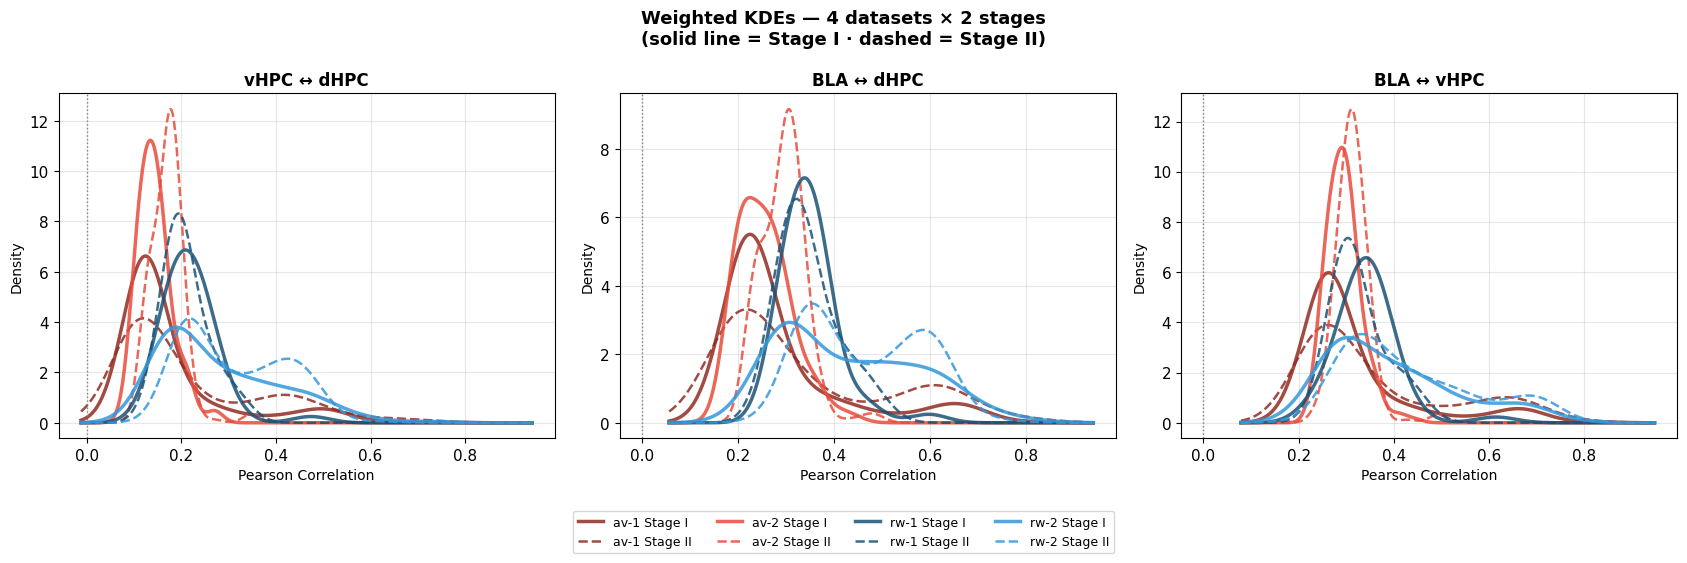

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
    ax = axes[pi]

    # Common range
    all_vals = np.concatenate([
        corr_cache[(name, stage, pair_label)][0]
        for name in DATASET_NAMES for stage in STAGES
        if len(corr_cache[(name, stage, pair_label)][0]) > 1
    ])
    x = np.linspace(all_vals.min() - 0.05, all_vals.max() + 0.05, 500)

    for name in DATASET_NAMES:
        for stage, ls in [('Stage I', '-'), ('Stage II', '--')]:
            d, w = corr_cache[(name, stage, pair_label)]
            if len(d) < 3:
                continue
            kde = stats.gaussian_kde(d, weights=w / w.sum(), bw_method='scott')
            lw  = 2.5 if ls == '-' else 1.8
            ax.plot(x, kde(x), color=COLORS[name], lw=lw, linestyle=ls,
                    label=f'{name} {stage}', alpha=0.85)

    ax.axvline(0, color='gray', linestyle=':', lw=1)
    ax.set_xlabel('Pearson Correlation', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(pair_label, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=9,
           frameon=True, bbox_to_anchor=(0.5, -0.12))

plt.suptitle('Weighted KDEs — 4 datasets × 2 stages\n'
             '(solid line = Stage I · dashed = Stage II)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Pairwise statistical tests across the 4 datasets

For each stage and each region pair:
- **Kruskal-Wallis**: global test (H0: all distributions identical)
- **Mann-Whitney U**: pairwise comparisons across 4 datasets (C(4,2) = 6 pairs)

In [8]:
dataset_pairs = list(combinations(DATASET_NAMES, 2))  # 6 pairs

for stage in STAGES:
    print(f"\n{'='*100}")
    print(f"  {stage}")
    print(f"{'='*100}")

    for n1, n2, pair_label, _ in PAIRS:
        groups = {name: corr_cache[(name, stage, pair_label)][0]
                  for name in DATASET_NAMES}

        # Kruskal-Wallis
        valid_groups = [g for g in groups.values() if len(g) >= 3]
        if len(valid_groups) >= 2:
            kw_stat, kw_p = stats.kruskal(*valid_groups)
            print(f"\n  {pair_label}")
            print(f"  Kruskal-Wallis: H={kw_stat:.3f}  p={kw_p:.4e}  {sig_label(kw_p)}")
        else:
            print(f"\n  {pair_label}  (insufficient data)")
            continue

        # Weighted means
        print(f"  {'Dataset':<8}  {'n':>5}  {'Weighted mean':>14}  {'Median':>10}")
        for name in DATASET_NAMES:
            d, w = corr_cache[(name, stage, pair_label)]
            wm, _ = weighted_mean_std(d, w) if len(d) > 0 else (np.nan, np.nan)
            print(f"  {name:<8}  {len(d):>5}  {wm:>+14.4f}  {np.median(d):>+10.4f}")

        # MWU pairwise
        print(f"  {'Comparison':<14}  {'MWU stat':>10}  {'p':>9}  {'Sig':>5}  "
              f"{'Δ weighted mean':>16}")
        print(f"  {'-'*61}")
        for (na, nb) in dataset_pairs:
            da, wa = corr_cache[(na, stage, pair_label)]
            db, wb = corr_cache[(nb, stage, pair_label)]
            u, p = mwu(da, db)
            if np.isnan(p):
                continue
            wma, _ = weighted_mean_std(da, wa)
            wmb, _ = weighted_mean_std(db, wb)
            delta = wma - wmb
            print(f"  {na} vs {nb:<6}  {u:>10.0f}  {p:>9.4f}  {sig_label(p):>5}  "
                  f"{delta:>+16.4f}")


  Stage I

  vHPC ↔ dHPC
  Kruskal-Wallis: H=248.341  p=1.4953e-53  ***
  Dataset       n   Weighted mean      Median
  av-1        520         +0.1755     +0.1382
  av-2         52         +0.1444     +0.1453
  rw-1         16         +0.2180     +0.1959
  rw-2        362         +0.2801     +0.2794
  Comparison        MWU stat          p    Sig   Δ weighted mean
  -------------------------------------------------------------
  av-1 vs av-2         13677     0.8905     ns           +0.0311
  av-1 vs rw-1          2378     0.0035     **           -0.0425
  av-1 vs rw-2         39343     0.0000    ***           -0.1046
  av-2 vs rw-1           128     0.0000    ***           -0.0736
  av-2 vs rw-2          1634     0.0000    ***           -0.1357
  rw-1 vs rw-2          1683     0.0046     **           -0.0621

  BLA ↔ dHPC
  Kruskal-Wallis: H=268.159  p=7.7213e-58  ***
  Dataset       n   Weighted mean      Median
  av-1        520         +0.2890     +0.2424
  av-2         52        

## Figure 5 — Summary: weighted means Stage I vs Stage II per dataset

Grouped bars showing the weighted mean for each dataset × stage × region pair.

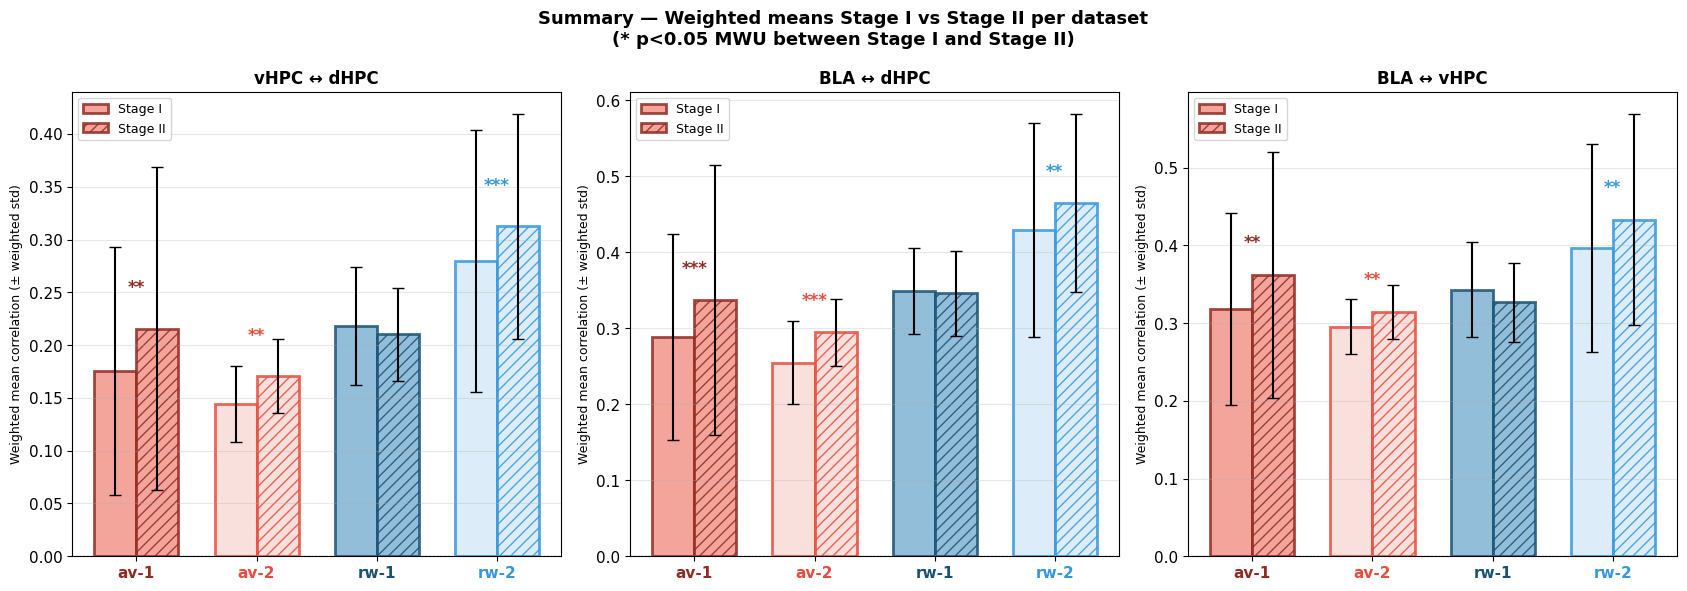

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(17, 6))

for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
    ax = axes[pi]

    x   = np.arange(len(DATASET_NAMES))
    w   = 0.35

    for si, (stage, hatch) in enumerate([('Stage I', ''), ('Stage II', '///')]):
        means = []
        errs  = []
        for name in DATASET_NAMES:
            d, wt = corr_cache[(name, stage, pair_label)]
            if len(d) > 0:
                m, s = weighted_mean_std(d, wt)
            else:
                m, s = np.nan, 0
            means.append(m)
            errs.append(s)

        offset = -w/2 if si == 0 else w/2
        bars = ax.bar(
            x + offset, means, w,
            yerr=errs, capsize=4,
            color=[FACE_COLORS[name] for name in DATASET_NAMES],
            edgecolor=[COLORS[name] for name in DATASET_NAMES],
            linewidth=2, hatch=hatch,
            label=stage, alpha=0.85, error_kw=dict(lw=1.5)
        )

        # MWU annotations Stage I vs Stage II
        for xi, name in zip(x, DATASET_NAMES):
            if si == 1:  # annotate after plotting Stage II
                da, wa = corr_cache[(name, 'Stage I',  pair_label)]
                db, wb = corr_cache[(name, 'Stage II', pair_label)]
                _, p = mwu(da, db)
                if not np.isnan(p) and p < 0.05:
                    ymax = max(
                        weighted_mean_std(da, wa)[0] if len(da)>0 else 0,
                        weighted_mean_std(db, wb)[0] if len(db)>0 else 0
                    )
                    ax.text(xi, ymax + 0.03, sig_label(p),
                            ha='center', va='bottom', fontsize=12,
                            fontweight='bold', color=COLORS[name])

    ax.set_xticks(x)
    ax.set_xticklabels(DATASET_NAMES, fontsize=11)
    ax.set_ylabel('Weighted mean correlation (± weighted std)', fontsize=9)
    ax.set_title(pair_label, fontsize=12, fontweight='bold')
    ax.axhline(0, color='gray', linestyle=':', lw=1)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=9)

    # Color xtick labels
    for tick, name in zip(ax.get_xticklabels(), DATASET_NAMES):
        tick.set_color(COLORS[name])
        tick.set_fontweight('bold')

plt.suptitle('Summary — Weighted means Stage I vs Stage II per dataset\n'
             '(* p<0.05 MWU between Stage I and Stage II)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Figure 6 — Rewarded vs Aversive: Stage II − Stage I shift

Datasets are pooled: **Aversive** = av-1 + av-2 (red), **Rewarded** = rw-1 + rw-2 (blue).

### How to read this figure

**Top row — Violin plots (4 violins per pair)**
- Each pair of violins shows Stage I (solid fill) vs Stage II (white hatch) for one condition.
- The **horizontal line** = duration-weighted mean.
- The **colored bracket between S1 and S2** (two-sided MWU) indicates whether correlations change significantly between stages *within a condition* (Δ = difference of weighted means).

**Bottom row — KDE density difference curve KDE(Stage II) − KDE(Stage I)**
- A **positive** value at a given r means Stage II has more epochs at that correlation level than Stage I.
- A **negative** value means the opposite.
- The **box in the lower right** contains the **interaction test**: does the S1→S2 shift differ between conditions?

### Interaction test (lower right box)

The statistic tested is:

> **Δ_RW − Δ_AV** = (mean_S2_RW − mean_S1_RW) − (mean_S2_AV − mean_S1_AV)

The test is a **permutation test** (10,000 iterations): condition labels (Rewarded / Aversive) are randomly reassigned to each stage separately, generating a null distribution of the difference in shifts.

### Quick interpretation
| Observation | Meaning |
|-------------|---------|
| Δ_RW > 0, Δ_AV ≈ 0 | The S1→S2 transition increases correlations only in the Rewarded condition |
| Δ_RW − Δ_AV significant | The effect of sleep stage on correlations depends on condition (interaction) |
| Rewarded KDE curve shifted right | Probability density shifts more toward high correlations in Rewarded |
| Δ_RW − Δ_AV not significant | Both conditions show the same S1→S2 change |

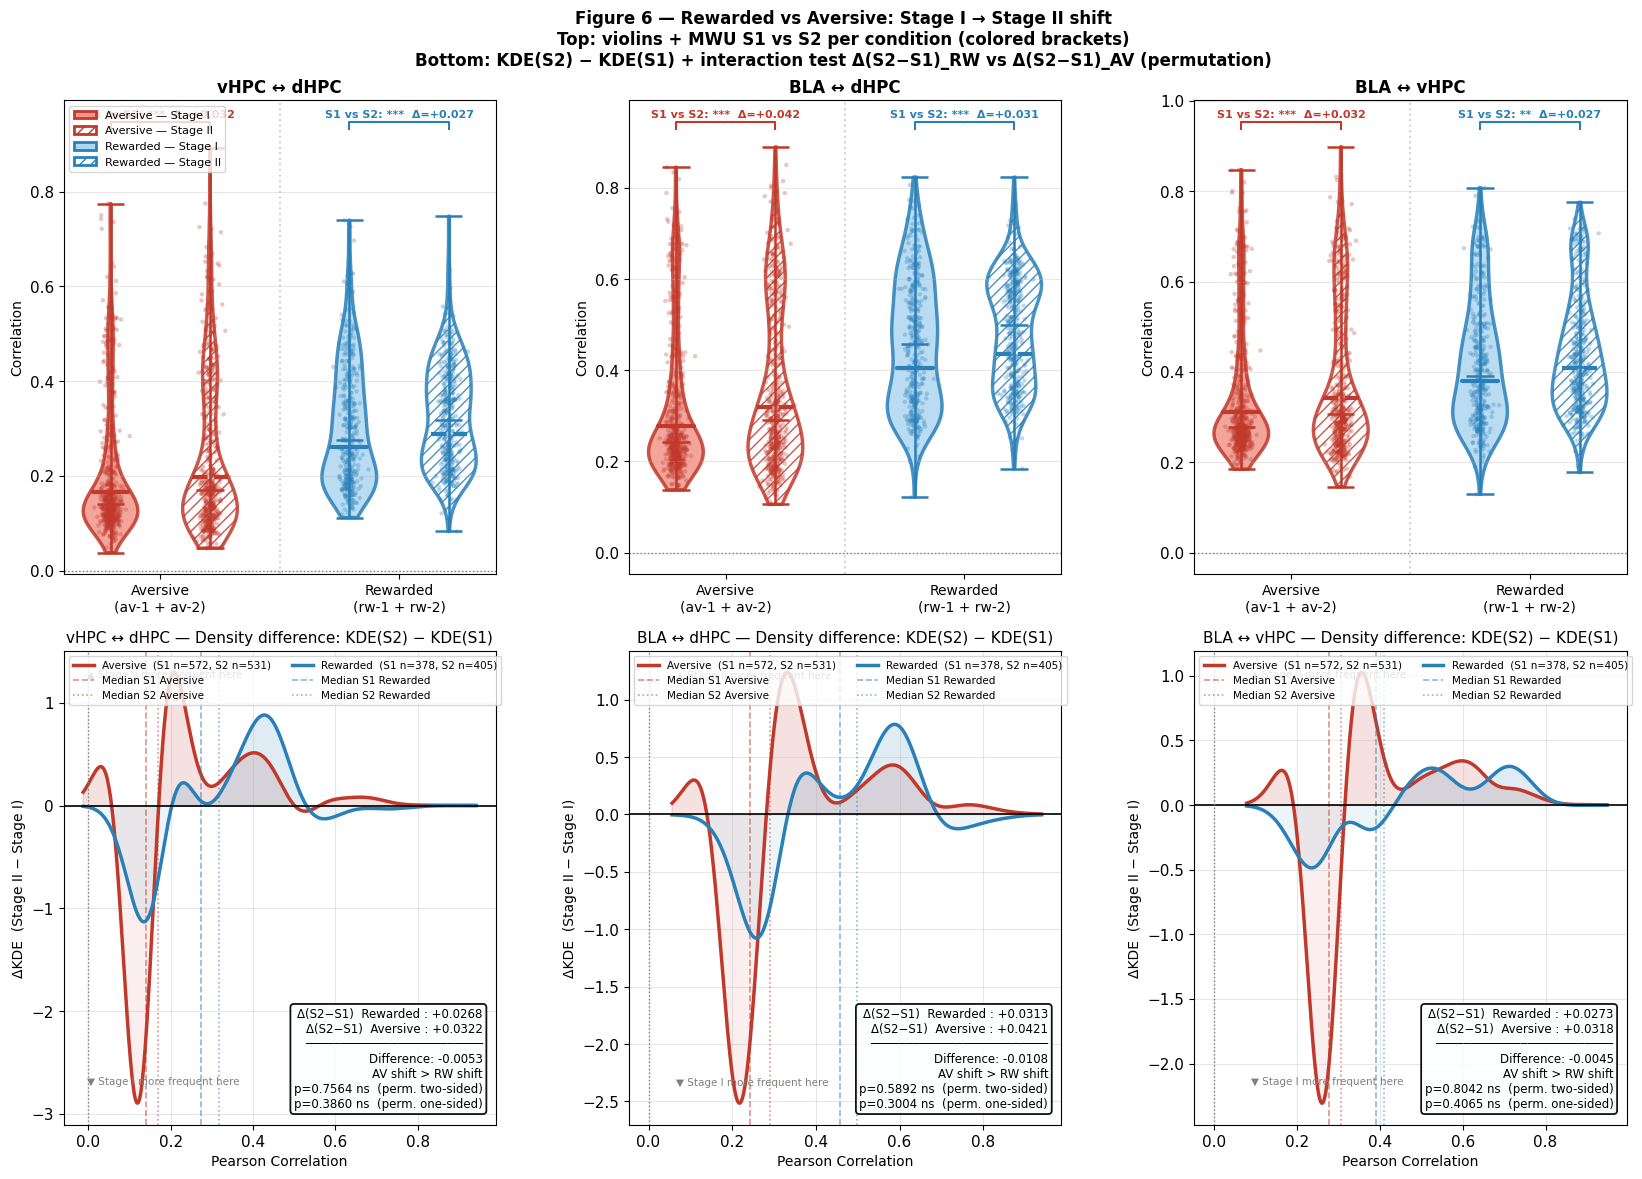

In [10]:
# --- Pool aversive (av-1 + av-2) and rewarded (rw-1 + rw-2) ---
CONDITIONS = {
    'Aversive': ['av-1', 'av-2'],
    'Rewarded': ['rw-1', 'rw-2'],
}
COND_COLORS = {'Aversive': '#c0392b', 'Rewarded': '#2980b9'}
COND_FACE   = {'Aversive': '#f1948a', 'Rewarded': '#aed6f1'}

pooled_cache = {}
for cond, names in CONDITIONS.items():
    for stage in STAGES:
        for _, _, pair_label, _ in PAIRS:
            all_c = np.concatenate([corr_cache[(n, stage, pair_label)][0] for n in names])
            all_w = np.concatenate([corr_cache[(n, stage, pair_label)][1] for n in names])
            pooled_cache[(cond, stage, pair_label)] = (all_c, all_w)


def mwu_one_sided(a, b, alternative='greater'):
    """One-sided MWU. alternative='greater' → H1: a > b."""
    if len(a) < 3 or len(b) < 3:
        return np.nan, np.nan
    stat, p = stats.mannwhitneyu(a, b, alternative=alternative)
    return stat, p


def test_interaction_shift(d_s1_rw, w_s1_rw, d_s2_rw, w_s2_rw,
                           d_s1_av, w_s1_av, d_s2_av, w_s2_av,
                           n_perm=10000):
    """
    Tests whether Δ(S2−S1) differs between Rewarded and Aversive.
    Observed statistic: (wmean_S2_RW − wmean_S1_RW) − (wmean_S2_AV − wmean_S1_AV)
    Permutation: condition labels are reassigned while keeping stage assignments fixed.
    """
    wm_s1_rw, _ = weighted_mean_std(d_s1_rw, w_s1_rw)
    wm_s2_rw, _ = weighted_mean_std(d_s2_rw, w_s2_rw)
    wm_s1_av, _ = weighted_mean_std(d_s1_av, w_s1_av)
    wm_s2_av, _ = weighted_mean_std(d_s2_av, w_s2_av)
    delta_rw = wm_s2_rw - wm_s1_rw
    delta_av = wm_s2_av - wm_s1_av
    observed = delta_rw - delta_av   # interaction statistic

    # Pool by stage, then randomly reassign conditions
    pool_s1   = np.concatenate([d_s1_rw, d_s1_av])
    pool_s2   = np.concatenate([d_s2_rw, d_s2_av])
    w_pool_s1 = np.concatenate([w_s1_rw, w_s1_av])
    w_pool_s2 = np.concatenate([w_s2_rw, w_s2_av])
    n_rw_s1, n_rw_s2 = len(d_s1_rw), len(d_s2_rw)

    rng = np.random.default_rng(42)
    perm_stats = np.empty(n_perm)
    for i in range(n_perm):
        idx1 = rng.permutation(len(pool_s1))
        idx2 = rng.permutation(len(pool_s2))

        a1, wa1 = pool_s1[idx1[:n_rw_s1]], w_pool_s1[idx1[:n_rw_s1]]
        b1, wb1 = pool_s1[idx1[n_rw_s1:]], w_pool_s1[idx1[n_rw_s1:]]
        a2, wa2 = pool_s2[idx2[:n_rw_s2]], w_pool_s2[idx2[:n_rw_s2]]
        b2, wb2 = pool_s2[idx2[n_rw_s2:]], w_pool_s2[idx2[n_rw_s2:]]

        wm_a1, _ = weighted_mean_std(a1, wa1)
        wm_a2, _ = weighted_mean_std(a2, wa2)
        wm_b1, _ = weighted_mean_std(b1, wb1)
        wm_b2, _ = weighted_mean_std(b2, wb2)
        perm_stats[i] = (wm_a2 - wm_a1) - (wm_b2 - wm_b1)

    p_two   = np.mean(np.abs(perm_stats) >= np.abs(observed))
    p_rw_gt = np.mean(perm_stats >= observed)   # H1: Δ_RW > Δ_AV
    return observed, delta_rw, delta_av, p_two, p_rw_gt


# ── Figure: 2 rows × 3 columns ──────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(17, 12))

for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):

    # ── Row 1: violins ────────────────────────────────────────────────────
    ax_v = axes[0, pi]

    configs = [
        ('Aversive', 'Stage I',  1  ),
        ('Aversive', 'Stage II', 2  ),
        ('Rewarded', 'Stage I',  3.4),
        ('Rewarded', 'Stage II', 4.4),
    ]

    for cond, stage, pos in configs:
        d, w = pooled_cache[(cond, stage, pair_label)]
        if len(d) < 2:
            continue
        fc    = COND_FACE[cond] if stage == 'Stage I' else '#ffffff'
        ec    = COND_COLORS[cond]
        hatch = ''              if stage == 'Stage I' else '///'

        vp = ax_v.violinplot([d], positions=[pos], showmedians=True, widths=0.55)
        vp['bodies'][0].set_facecolor(fc)
        vp['bodies'][0].set_edgecolor(ec)
        vp['bodies'][0].set_linewidth(2.5)
        vp['bodies'][0].set_alpha(0.85)
        vp['bodies'][0].set_hatch(hatch)
        for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
            vp[part].set_color(ec); vp[part].set_linewidth(1.8)

        np.random.seed(42)
        ax_v.scatter(np.random.normal(pos, 0.05, len(d)), d,
                     alpha=0.3, s=10, color=ec, edgecolors='none')

        wm, _ = weighted_mean_std(d, w)
        ls = '-' if stage == 'Stage I' else '--'
        ax_v.plot([pos - 0.18, pos + 0.18], [wm, wm],
                  color=ec, lw=3, linestyle=ls, solid_capstyle='round')

    # --- Brackets: S1 vs S2 within each condition (two-sided MWU) ---
    y_top_all = max(
        pooled_cache[(c, s, pair_label)][0].max()
        for c in CONDITIONS for s in STAGES
        if len(pooled_cache[(c, s, pair_label)][0]) > 0
    )
    bracket_base = y_top_all + 0.04

    for cond, x_mid, x_l, x_r in [('Aversive', 1.5, 1, 2),
                                    ('Rewarded', 3.9, 3.4, 4.4)]:
        d1, w1 = pooled_cache[(cond, 'Stage I',  pair_label)]
        d2, w2 = pooled_cache[(cond, 'Stage II', pair_label)]
        _, p = mwu(d1, d2)
        if not np.isnan(p):
            wm1, _ = weighted_mean_std(d1, w1)
            wm2, _ = weighted_mean_std(d2, w2)
            delta = wm2 - wm1
            yb = bracket_base
            ax_v.plot([x_l, x_l, x_r, x_r], [yb, yb+.015, yb+.015, yb],
                      color=COND_COLORS[cond], lw=1.5)
            ax_v.text(x_mid, yb + 0.02,
                      f'S1 vs S2: {sig_label(p)}  Δ={delta:+.3f}',
                      ha='center', va='bottom', fontsize=8,
                      color=COND_COLORS[cond], fontweight='bold')

    ax_v.axvline(2.7, color='lightgray', lw=1.5, linestyle=':')
    ax_v.set_xticks([1.5, 3.9])
    ax_v.set_xticklabels(['Aversive\n(av-1 + av-2)', 'Rewarded\n(rw-1 + rw-2)'], fontsize=10)
    ax_v.set_ylabel('Correlation', fontsize=10)
    ax_v.set_title(pair_label, fontsize=12, fontweight='bold')
    ax_v.axhline(0, color='gray', linestyle=':', lw=1)
    ax_v.grid(True, alpha=0.3, axis='y')

    if pi == 0:
        from matplotlib.patches import Patch
        legend_els = [
            Patch(fc=COND_FACE['Aversive'], ec=COND_COLORS['Aversive'], lw=2,
                  label='Aversive — Stage I'),
            Patch(fc='white', ec=COND_COLORS['Aversive'], lw=2, hatch='///',
                  label='Aversive — Stage II'),
            Patch(fc=COND_FACE['Rewarded'], ec=COND_COLORS['Rewarded'], lw=2,
                  label='Rewarded — Stage I'),
            Patch(fc='white', ec=COND_COLORS['Rewarded'], lw=2, hatch='///',
                  label='Rewarded — Stage II'),
        ]
        ax_v.legend(handles=legend_els, fontsize=8, loc='upper left')

    # ── Row 2: KDE(S2) − KDE(S1) + interaction test Δ_RW vs Δ_AV ─────
    ax_k = axes[1, pi]

    all_vals = np.concatenate([
        pooled_cache[(cond, stage, pair_label)][0]
        for cond in CONDITIONS for stage in STAGES
        if len(pooled_cache[(cond, stage, pair_label)][0]) > 1
    ])
    x_grid = np.linspace(all_vals.min() - 0.05, all_vals.max() + 0.05, 500)

    for cond in CONDITIONS:
        d1, w1 = pooled_cache[(cond, 'Stage I',  pair_label)]
        d2, w2 = pooled_cache[(cond, 'Stage II', pair_label)]
        if len(d1) < 3 or len(d2) < 3:
            continue
        kde1 = stats.gaussian_kde(d1, weights=w1/w1.sum(), bw_method='scott')
        kde2 = stats.gaussian_kde(d2, weights=w2/w2.sum(), bw_method='scott')
        diff = kde2(x_grid) - kde1(x_grid)

        color = COND_COLORS[cond]
        ax_k.plot(x_grid, diff, color=color, lw=2.5,
                  label=f'{cond}  (S1 n={len(d1)}, S2 n={len(d2)})')
        ax_k.fill_between(x_grid, diff, 0, where=diff > 0, alpha=0.15, color=color)
        ax_k.fill_between(x_grid, diff, 0, where=diff < 0, alpha=0.08, color=color)
        ax_k.axvline(np.median(d1), color=color, lw=1.2, linestyle='--', alpha=0.55,
                     label=f'Median S1 {cond}')
        ax_k.axvline(np.median(d2), color=color, lw=1.2, linestyle=':',  alpha=0.55,
                     label=f'Median S2 {cond}')

    # --- Interaction test: Δ(S2−S1)_RW vs Δ(S2−S1)_AV (permutation) ---
    d_s1_rw, w_s1_rw = pooled_cache[('Rewarded', 'Stage I',  pair_label)]
    d_s2_rw, w_s2_rw = pooled_cache[('Rewarded', 'Stage II', pair_label)]
    d_s1_av, w_s1_av = pooled_cache[('Aversive', 'Stage I',  pair_label)]
    d_s2_av, w_s2_av = pooled_cache[('Aversive', 'Stage II', pair_label)]

    obs, delta_rw, delta_av, p_two, p_rw_gt = test_interaction_shift(
        d_s1_rw, w_s1_rw, d_s2_rw, w_s2_rw,
        d_s1_av, w_s1_av, d_s2_av, w_s2_av
    )
    direction = 'RW shift > AV shift' if obs > 0 else 'AV shift > RW shift'
    p_dir = p_rw_gt if obs > 0 else (1 - p_rw_gt)

    ann_text = (
        f'Δ(S2−S1)  Rewarded : {delta_rw:+.4f}\n'
        f'Δ(S2−S1)  Aversive : {delta_av:+.4f}\n'
        f'─────────────────────────\n'
        f'Difference: {obs:+.4f}\n'
        f'{direction}\n'
        f'p={p_two:.4f} {sig_label(p_two)}  (perm. two-sided)\n'
        f'p={p_dir:.4f} {sig_label(p_dir)}  (perm. one-sided)'
    )
    ax_k.text(0.97, 0.03, ann_text,
              transform=ax_k.transAxes, fontsize=8.5,
              va='bottom', ha='right',
              bbox=dict(boxstyle='round', facecolor='#FDFEFE',
                        alpha=0.93, edgecolor='black', linewidth=1.3))

    ax_k.axhline(0, color='black', lw=1.2)
    ax_k.axvline(0, color='gray',  lw=1, linestyle=':')
    ax_k.set_xlabel('Pearson Correlation', fontsize=10)
    ax_k.set_ylabel('ΔKDE  (Stage II − Stage I)', fontsize=10)
    ax_k.set_title(f'{pair_label} — Density difference: KDE(S2) − KDE(S1)', fontsize=11)
    ax_k.legend(fontsize=7.5, ncol=2, loc='upper left')
    ax_k.grid(True, alpha=0.3)

    # Annotations for positive/negative zones
    yl = ax_k.get_ylim()
    ax_k.text(x_grid[0] + 0.01, yl[1] * 0.88, '▲ Stage II more frequent here',
              fontsize=7.5, color='gray', va='top')
    ax_k.text(x_grid[0] + 0.01, yl[0] * 0.88, '▼ Stage I more frequent here',
              fontsize=7.5, color='gray', va='bottom')

plt.suptitle(
    'Figure 6 — Rewarded vs Aversive: Stage I → Stage II shift\n'
    'Top: violins + MWU S1 vs S2 per condition (colored brackets)\n'
    "Bottom: KDE(S2) − KDE(S1) + interaction test Δ(S2−S1)_RW vs Δ(S2−S1)_AV (permutation)",
    fontsize=12, fontweight='bold'
)
plt.tight_layout()
plt.show()